In [1]:
# importing the libraries
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from IPython.display import clear_output


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
!unzip '/content/drive/Shareddrives/ShupponKu/split-output-wsample.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split-output/train/masks/148381_mask_32.jpg  
  inflating: split-output/train/masks/208695_mask_81.jpg  
  inflating: split-output/train/masks/825816_mask_18.jpg  
  inflating: split-output/train/masks/626208_mask_58.jpg  
  inflating: split-output/train/masks/925425_mask_53.jpg  
  inflating: split-output/train/masks/277900_mask_14.jpg  
  inflating: split-output/train/masks/134465_mask_34.jpg  
  inflating: split-output/train/masks/277900_mask_75.jpg  
  inflating: split-output/train/masks/325354_mask_64.jpg  
  inflating: split-output/train/masks/325354_mask_82.jpg  
  inflating: split-output/train/masks/715846_mask_35.jpg  
  inflating: split-output/train/masks/533952_mask_16.jpg  
  inflating: split-output/train/masks/334677_mask_57.jpg  
  inflating: split-output/train/masks/192918_mask_20.jpg  
  inflating: split-output/train/masks/334677_mask_65.jpg  
  inflating: split-output/train/masks/866782_mask_84.jpg  
  inf

In [4]:
data_dir = '/content/split-output/'

In [5]:
train_folder= os.path.join(data_dir,'train')
valid_folder= os.path.join(data_dir,'val')
sample_folder= os.path.join(data_dir,'sample')
test_folder= os.path.join(data_dir,'test')
num_of_training_img = len(os.listdir(train_folder + '/images')) 
num_of_training_mask = len(os.listdir(train_folder + '/masks'))
num_of_val_img = len(os.listdir(valid_folder + '/images'))
num_of_test_img = len(os.listdir(test_folder + '/images'))

In [6]:
print(f"There are {num_of_training_img} images.\n")
print(f"There are {num_of_training_mask} masks.\n")

There are 4086 images.

There are 4086 masks.



--BATAS SUCI--

In [7]:
train_dir=train_folder
val_dir=valid_folder
test_dir=test_folder
sample_dir = sample_folder

In [8]:
img_dim = 256
BATCH_SIZE = 32 
seed = 42

In [9]:
from PIL import Image
import random
import seaborn as sns

In [10]:
tr_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_image_generator = tr_datagen.flow_from_directory(
        train_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,
)
    
train_mask_generator = tr_datagen.flow_from_directory(
        train_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)

val_image_generator = val_datagen.flow_from_directory(
        val_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
val_mask_generator = val_datagen.flow_from_directory(
        val_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)
test_image_generator = val_datagen.flow_from_directory(
        test_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
test_mask_generator = val_datagen.flow_from_directory(
        test_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)
sam_image_generator = val_datagen.flow_from_directory(
        sample_folder,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
sam_mask_generator = val_datagen.flow_from_directory(
        sample_folder,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)
sample_generator = zip(sam_image_generator, sam_mask_generator)

Found 4086 images belonging to 1 classes.
Found 4086 images belonging to 1 classes.
Found 510 images belonging to 1 classes.
Found 510 images belonging to 1 classes.
Found 512 images belonging to 1 classes.
Found 512 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


In [11]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
        plt.axis('off')
    plt.show()

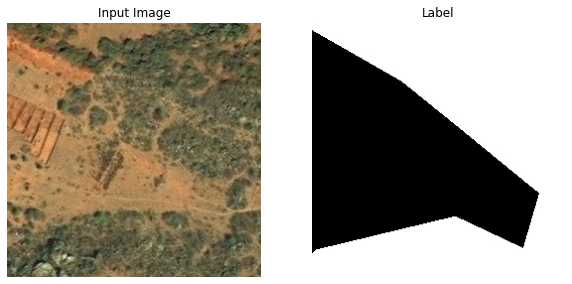

In [12]:
num_sample = 1
n = 0
# print(train_image_generator.shape)
for image, mask in sample_generator:
    sample_image, sample_label = image[0], mask[0]
    if n < num_sample:
        display([sample_image, sample_label])
        n+=1
    else:
        break

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [14]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, activation='elu', kernel_initializer='he_normal', padding="same")(input)
    x = Dropout(0.1)(x)    
    x = Conv2D(num_filters, 3, activation='elu', kernel_initializer='he_normal', padding="same")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256)

    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = Conv2D(1, 1, activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [16]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=0.0001):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32')
    intersect = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    fsum = K.sum(y_true,[1,2,3])
    ssum = K.sum(y_pred,[1,2,3])
    dice = (2 * intersect + smooth) / (fsum + ssum + smooth)
    dice = K.mean(dice)
    return dice  

def iou_coef(y_true, y_pred, smooth=0.0001):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
# defining the tensorflow distribute strategy
# strategy = tf.distribute.MirroredStrategy()

In [17]:
# # calling the model inside the scope
# with strategy.scope():
model = build_unet((img_dim, img_dim, 3))
# compiling the model with the optimizer, loss function and acc metrics
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[iou_coef,dice_coef,'accuracy', 'mse'])

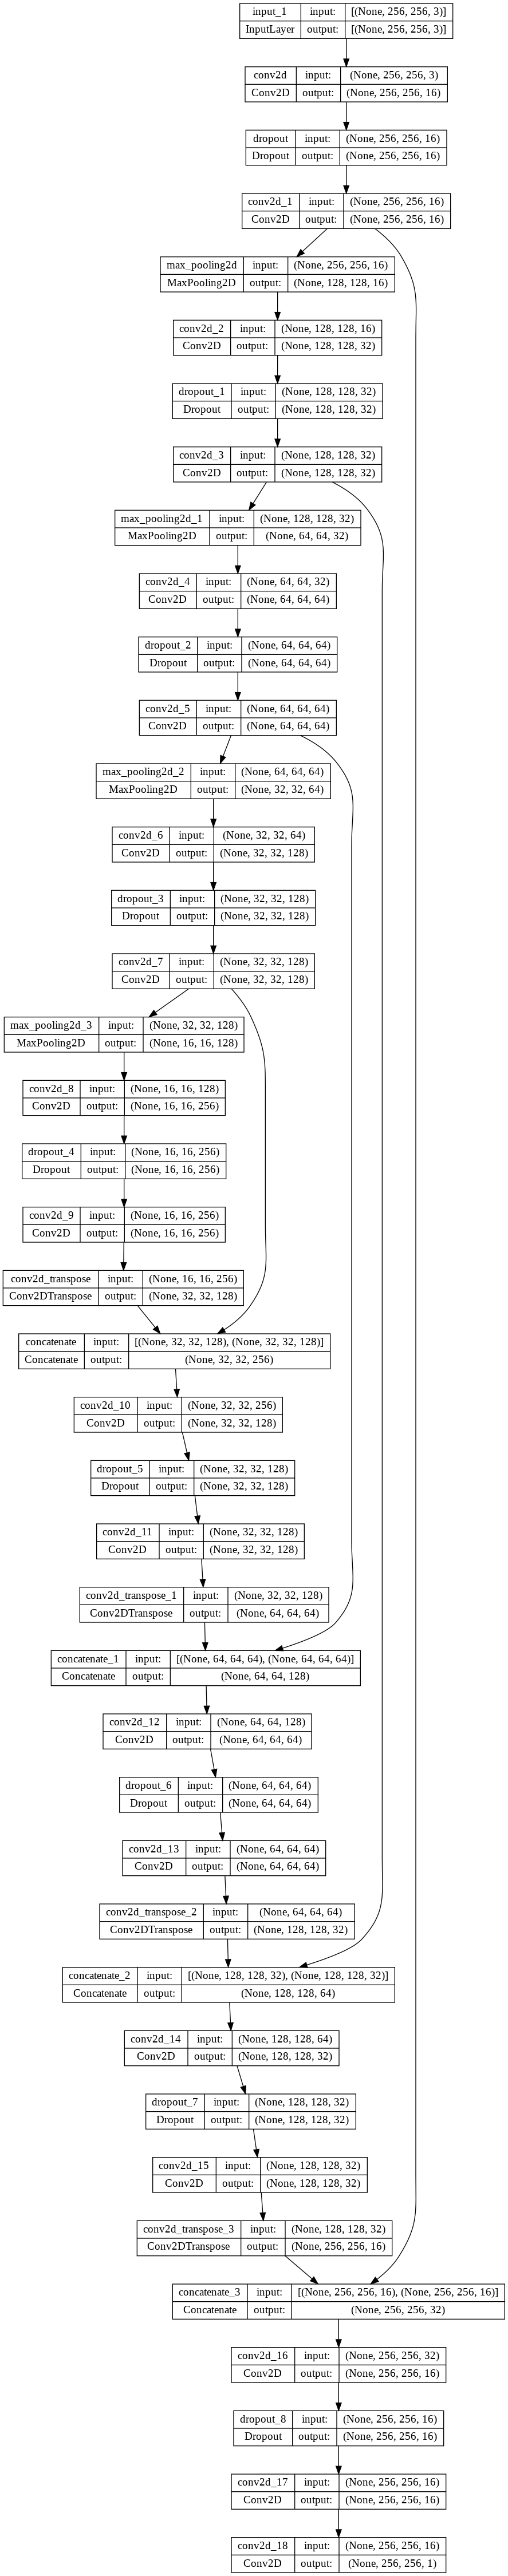

In [18]:
# let's see how our FCN implemented model looks like
# does it looks like the architecture fig above?
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
# function to show the prediction
def show_predictions(dataset=None, num=1):
  if dataset:
    n = 0
    for image, mask in dataset:
      image, mask = image, mask
      if n < num:
        # pred_mask = model.predict(image)
        # print(pred_mask)
        result = model.predict(image)
        output = result[0]
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        print(f'image shape {image.shape}')
        print(f'mask shape {mask.shape}')
        print(f'pred_mask shape {result.shape}')
        display([image[0], mask[0], output])
        n+=1
      else:
        break
  else:
    result = model.predict(sample_image[tf.newaxis, ...])
    output = result[0]
    output[output >= 0.5] = 1
    output[output < 0.5] = 0
    display([sample_image, sample_label, output])

1/1 [==============================] - 10s 10s/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


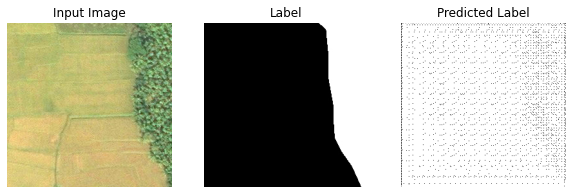

In [20]:
# # Let's see a sample of input image it's true mask and what our model is predicted given the input image
show_predictions(test_generator)

In [21]:
# calllback to displaying the predictions of our model while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
   
 # ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = 1)


Epoch 1/50
1/1 [==============================] - 1s 662ms/step


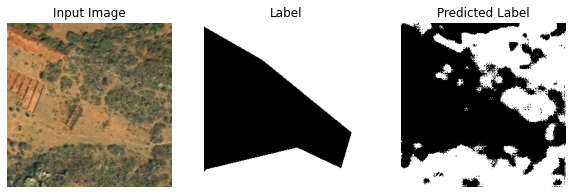


Sample Prediction after epoch 1

127/127 [==============================] - 94s 711ms/step - loss: 0.6275 - iou_coef: 0.5495 - dice_coef: 0.6470 - accuracy: 0.6558 - mse: 0.2158 - val_loss: 0.6005 - val_iou_coef: 0.4975 - val_dice_coef: 0.5875 - val_accuracy: 0.6860 - val_mse: 0.2055 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 18ms/step


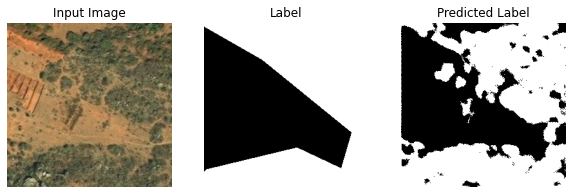


Sample Prediction after epoch 2

127/127 [==============================] - 93s 712ms/step - loss: 0.6171 - iou_coef: 0.5623 - dice_coef: 0.6571 - accuracy: 0.6697 - mse: 0.2105 - val_loss: 0.5870 - val_iou_coef: 0.5438 - val_dice_coef: 0.6398 - val_accuracy: 0.7026 - val_mse: 0.1992 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 20ms/step


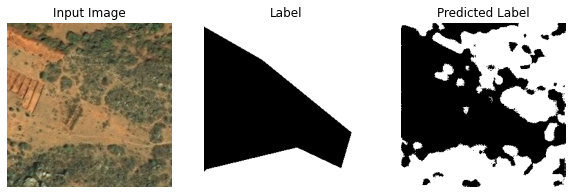


Sample Prediction after epoch 3

127/127 [==============================] - 91s 720ms/step - loss: 0.6040 - iou_coef: 0.5599 - dice_coef: 0.6564 - accuracy: 0.6741 - mse: 0.2061 - val_loss: 0.5902 - val_iou_coef: 0.5124 - val_dice_coef: 0.6067 - val_accuracy: 0.6943 - val_mse: 0.2007 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 0s 23ms/step


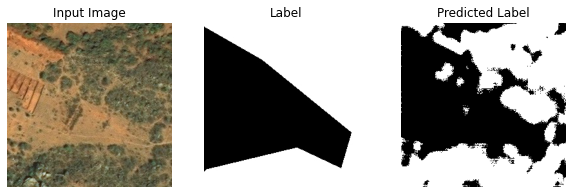


Sample Prediction after epoch 4

127/127 [==============================] - 90s 709ms/step - loss: 0.5973 - iou_coef: 0.5632 - dice_coef: 0.6583 - accuracy: 0.6808 - mse: 0.2030 - val_loss: 0.5830 - val_iou_coef: 0.5229 - val_dice_coef: 0.6157 - val_accuracy: 0.7013 - val_mse: 0.1975 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 17ms/step


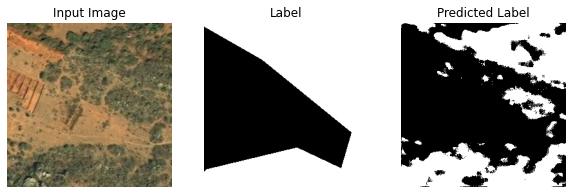


Sample Prediction after epoch 5

127/127 [==============================] - 91s 720ms/step - loss: 0.5917 - iou_coef: 0.5698 - dice_coef: 0.6634 - accuracy: 0.6873 - mse: 0.2002 - val_loss: 0.5992 - val_iou_coef: 0.4738 - val_dice_coef: 0.5674 - val_accuracy: 0.6768 - val_mse: 0.2053 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 0s 17ms/step


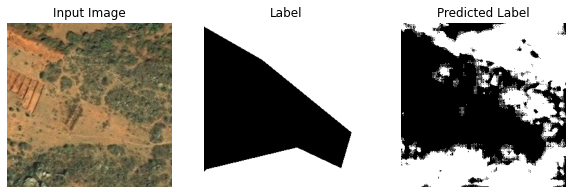


Sample Prediction after epoch 6

127/127 [==============================] - 90s 714ms/step - loss: 0.5910 - iou_coef: 0.5692 - dice_coef: 0.6630 - accuracy: 0.6870 - mse: 0.1999 - val_loss: 0.5810 - val_iou_coef: 0.5158 - val_dice_coef: 0.6070 - val_accuracy: 0.7006 - val_mse: 0.1968 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - 0s 24ms/step


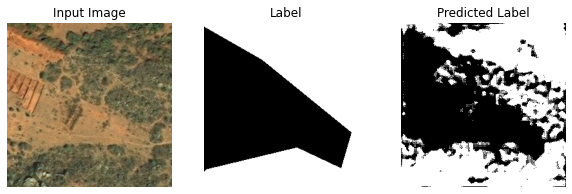


Sample Prediction after epoch 7

127/127 [==============================] - 91s 719ms/step - loss: 0.5867 - iou_coef: 0.5741 - dice_coef: 0.6665 - accuracy: 0.6926 - mse: 0.1979 - val_loss: 0.5770 - val_iou_coef: 0.5323 - val_dice_coef: 0.6265 - val_accuracy: 0.7067 - val_mse: 0.1950 - lr: 0.0010
Epoch 8/50
1/1 [==============================] - 0s 16ms/step


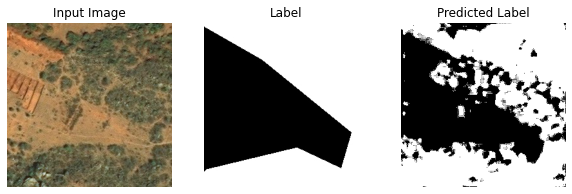


Sample Prediction after epoch 8

127/127 [==============================] - 90s 709ms/step - loss: 0.5803 - iou_coef: 0.5816 - dice_coef: 0.6739 - accuracy: 0.6973 - mse: 0.1953 - val_loss: 0.5654 - val_iou_coef: 0.5493 - val_dice_coef: 0.6444 - val_accuracy: 0.7133 - val_mse: 0.1902 - lr: 0.0010
Epoch 9/50
1/1 [==============================] - 0s 19ms/step


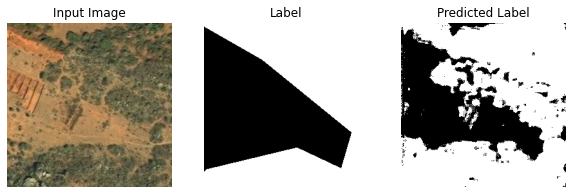


Sample Prediction after epoch 9

127/127 [==============================] - 89s 708ms/step - loss: 0.5800 - iou_coef: 0.5773 - dice_coef: 0.6698 - accuracy: 0.6972 - mse: 0.1951 - val_loss: 0.5523 - val_iou_coef: 0.5872 - val_dice_coef: 0.6795 - val_accuracy: 0.7309 - val_mse: 0.1839 - lr: 0.0010
Epoch 10/50
1/1 [==============================] - 0s 18ms/step


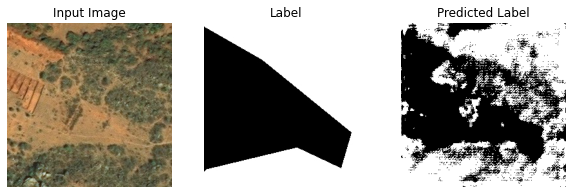


Sample Prediction after epoch 10

127/127 [==============================] - 92s 726ms/step - loss: 0.5749 - iou_coef: 0.5808 - dice_coef: 0.6731 - accuracy: 0.7003 - mse: 0.1930 - val_loss: 0.5993 - val_iou_coef: 0.5077 - val_dice_coef: 0.6181 - val_accuracy: 0.6795 - val_mse: 0.2055 - lr: 0.0010
Epoch 11/50
1/1 [==============================] - 0s 17ms/step


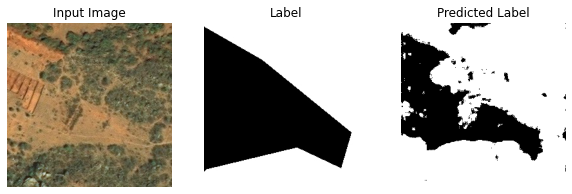


Sample Prediction after epoch 11

127/127 [==============================] - 91s 716ms/step - loss: 0.5740 - iou_coef: 0.5827 - dice_coef: 0.6756 - accuracy: 0.7019 - mse: 0.1927 - val_loss: 0.5390 - val_iou_coef: 0.6190 - val_dice_coef: 0.7087 - val_accuracy: 0.7414 - val_mse: 0.1783 - lr: 0.0010
Epoch 12/50
1/1 [==============================] - 0s 17ms/step


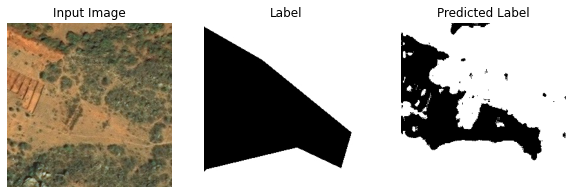


Sample Prediction after epoch 12

127/127 [==============================] - 92s 726ms/step - loss: 0.5702 - iou_coef: 0.5818 - dice_coef: 0.6744 - accuracy: 0.7031 - mse: 0.1912 - val_loss: 0.5373 - val_iou_coef: 0.6273 - val_dice_coef: 0.7159 - val_accuracy: 0.7418 - val_mse: 0.1778 - lr: 0.0010
Epoch 13/50
1/1 [==============================] - 0s 18ms/step


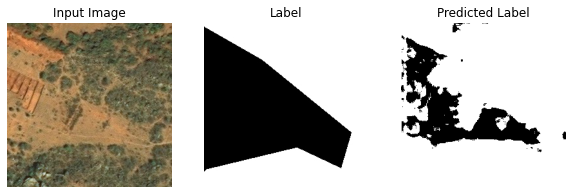


Sample Prediction after epoch 13

127/127 [==============================] - 90s 714ms/step - loss: 0.5647 - iou_coef: 0.5873 - dice_coef: 0.6796 - accuracy: 0.7081 - mse: 0.1886 - val_loss: 0.5572 - val_iou_coef: 0.6380 - val_dice_coef: 0.7242 - val_accuracy: 0.7301 - val_mse: 0.1859 - lr: 0.0010
Epoch 14/50
1/1 [==============================] - 0s 17ms/step


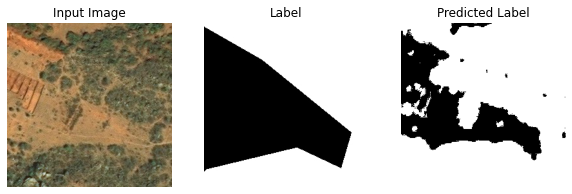


Sample Prediction after epoch 14

127/127 [==============================] - 91s 720ms/step - loss: 0.5643 - iou_coef: 0.5871 - dice_coef: 0.6794 - accuracy: 0.7076 - mse: 0.1887 - val_loss: 0.5310 - val_iou_coef: 0.6297 - val_dice_coef: 0.7173 - val_accuracy: 0.7470 - val_mse: 0.1751 - lr: 0.0010
Epoch 15/50
1/1 [==============================] - 0s 17ms/step


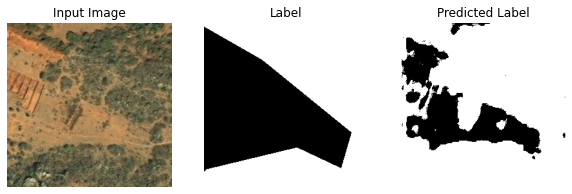


Sample Prediction after epoch 15

127/127 [==============================] - 90s 711ms/step - loss: 0.5594 - iou_coef: 0.5942 - dice_coef: 0.6865 - accuracy: 0.7111 - mse: 0.1866 - val_loss: 0.5357 - val_iou_coef: 0.6367 - val_dice_coef: 0.7233 - val_accuracy: 0.7441 - val_mse: 0.1769 - lr: 0.0010
Epoch 16/50
1/1 [==============================] - 0s 17ms/step


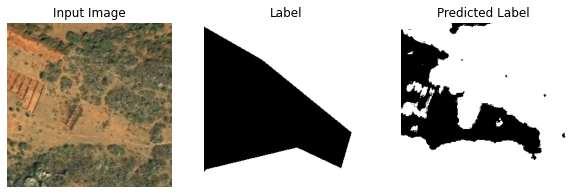


Sample Prediction after epoch 16

127/127 [==============================] - 91s 719ms/step - loss: 0.5624 - iou_coef: 0.5916 - dice_coef: 0.6837 - accuracy: 0.7091 - mse: 0.1877 - val_loss: 0.5295 - val_iou_coef: 0.6328 - val_dice_coef: 0.7196 - val_accuracy: 0.7484 - val_mse: 0.1744 - lr: 0.0010
Epoch 17/50
1/1 [==============================] - 0s 17ms/step


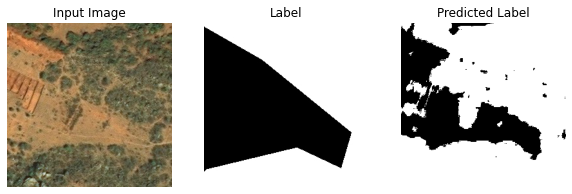


Sample Prediction after epoch 17

127/127 [==============================] - 90s 710ms/step - loss: 0.5506 - iou_coef: 0.5969 - dice_coef: 0.6876 - accuracy: 0.7169 - mse: 0.1829 - val_loss: 0.5281 - val_iou_coef: 0.6231 - val_dice_coef: 0.7119 - val_accuracy: 0.7498 - val_mse: 0.1736 - lr: 0.0010
Epoch 18/50
1/1 [==============================] - 0s 17ms/step


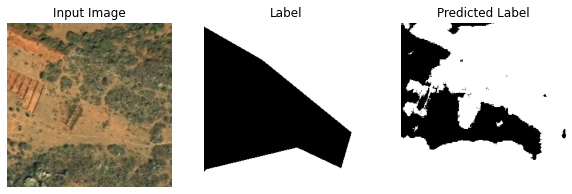


Sample Prediction after epoch 18

127/127 [==============================] - 90s 709ms/step - loss: 0.5492 - iou_coef: 0.5979 - dice_coef: 0.6898 - accuracy: 0.7167 - mse: 0.1823 - val_loss: 0.5255 - val_iou_coef: 0.6255 - val_dice_coef: 0.7137 - val_accuracy: 0.7516 - val_mse: 0.1725 - lr: 0.0010
Epoch 19/50
1/1 [==============================] - 0s 17ms/step


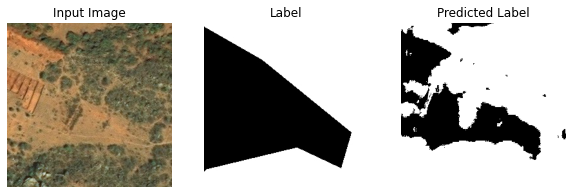


Sample Prediction after epoch 19

127/127 [==============================] - 91s 722ms/step - loss: 0.5505 - iou_coef: 0.5948 - dice_coef: 0.6865 - accuracy: 0.7163 - mse: 0.1828 - val_loss: 0.5214 - val_iou_coef: 0.6284 - val_dice_coef: 0.7182 - val_accuracy: 0.7504 - val_mse: 0.1712 - lr: 0.0010
Epoch 20/50
1/1 [==============================] - 0s 20ms/step


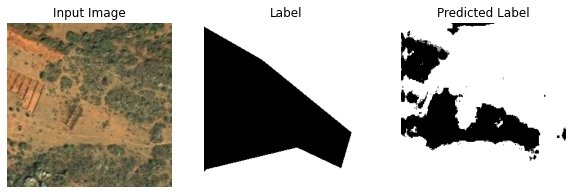


Sample Prediction after epoch 20

127/127 [==============================] - 90s 712ms/step - loss: 0.5517 - iou_coef: 0.5987 - dice_coef: 0.6926 - accuracy: 0.7168 - mse: 0.1829 - val_loss: 0.5193 - val_iou_coef: 0.6356 - val_dice_coef: 0.7238 - val_accuracy: 0.7520 - val_mse: 0.1703 - lr: 0.0010
Epoch 21/50
1/1 [==============================] - 0s 16ms/step


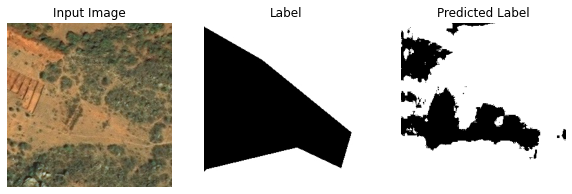


Sample Prediction after epoch 21

127/127 [==============================] - 91s 716ms/step - loss: 0.5484 - iou_coef: 0.5943 - dice_coef: 0.6882 - accuracy: 0.7178 - mse: 0.1819 - val_loss: 0.5228 - val_iou_coef: 0.6370 - val_dice_coef: 0.7247 - val_accuracy: 0.7492 - val_mse: 0.1718 - lr: 0.0010
Epoch 22/50
1/1 [==============================] - 0s 23ms/step


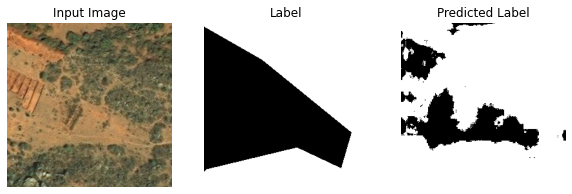


Sample Prediction after epoch 22

127/127 [==============================] - 89s 707ms/step - loss: 0.5420 - iou_coef: 0.6005 - dice_coef: 0.6941 - accuracy: 0.7212 - mse: 0.1793 - val_loss: 0.5309 - val_iou_coef: 0.6399 - val_dice_coef: 0.7266 - val_accuracy: 0.7458 - val_mse: 0.1749 - lr: 0.0010
Epoch 23/50
1/1 [==============================] - 0s 17ms/step


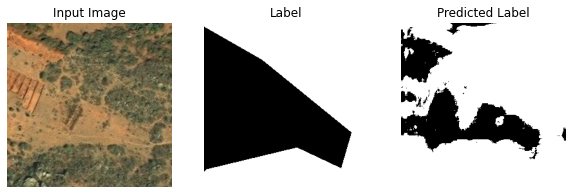


Sample Prediction after epoch 23

127/127 [==============================] - 90s 715ms/step - loss: 0.5452 - iou_coef: 0.5998 - dice_coef: 0.6926 - accuracy: 0.7200 - mse: 0.1806 - val_loss: 0.5197 - val_iou_coef: 0.6360 - val_dice_coef: 0.7247 - val_accuracy: 0.7528 - val_mse: 0.1704 - lr: 0.0010
Epoch 24/50
1/1 [==============================] - 0s 17ms/step


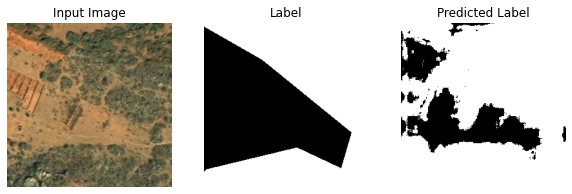


Sample Prediction after epoch 24

127/127 [==============================] - 90s 709ms/step - loss: 0.5409 - iou_coef: 0.5988 - dice_coef: 0.6922 - accuracy: 0.7233 - mse: 0.1787 - val_loss: 0.5172 - val_iou_coef: 0.6367 - val_dice_coef: 0.7253 - val_accuracy: 0.7535 - val_mse: 0.1695 - lr: 0.0010
Epoch 25/50
1/1 [==============================] - 0s 21ms/step


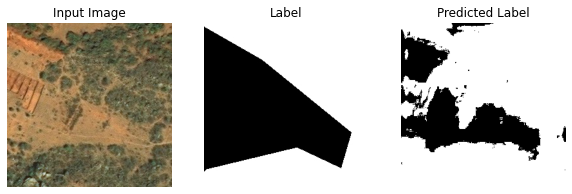


Sample Prediction after epoch 25

127/127 [==============================] - 90s 711ms/step - loss: 0.5406 - iou_coef: 0.6021 - dice_coef: 0.6945 - accuracy: 0.7239 - mse: 0.1786 - val_loss: 0.5094 - val_iou_coef: 0.6305 - val_dice_coef: 0.7204 - val_accuracy: 0.7592 - val_mse: 0.1663 - lr: 0.0010
Epoch 26/50
1/1 [==============================] - 0s 17ms/step


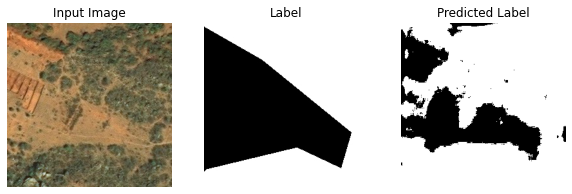


Sample Prediction after epoch 26

127/127 [==============================] - 91s 719ms/step - loss: 0.5332 - iou_coef: 0.6075 - dice_coef: 0.7005 - accuracy: 0.7291 - mse: 0.1755 - val_loss: 0.5174 - val_iou_coef: 0.6240 - val_dice_coef: 0.7152 - val_accuracy: 0.7553 - val_mse: 0.1693 - lr: 0.0010
Epoch 27/50
1/1 [==============================] - 0s 18ms/step


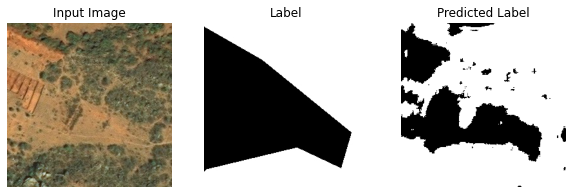


Sample Prediction after epoch 27

127/127 [==============================] - 90s 712ms/step - loss: 0.5315 - iou_coef: 0.6096 - dice_coef: 0.7017 - accuracy: 0.7305 - mse: 0.1748 - val_loss: 0.5180 - val_iou_coef: 0.6235 - val_dice_coef: 0.7151 - val_accuracy: 0.7556 - val_mse: 0.1693 - lr: 0.0010
Epoch 28/50
1/1 [==============================] - 0s 17ms/step


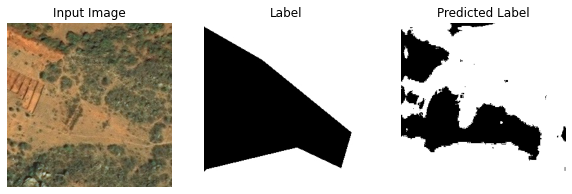


Sample Prediction after epoch 28

127/127 [==============================] - 91s 718ms/step - loss: 0.5306 - iou_coef: 0.6097 - dice_coef: 0.7016 - accuracy: 0.7301 - mse: 0.1745 - val_loss: 0.5198 - val_iou_coef: 0.6270 - val_dice_coef: 0.7169 - val_accuracy: 0.7543 - val_mse: 0.1701 - lr: 0.0010
Epoch 29/50
1/1 [==============================] - 0s 17ms/step


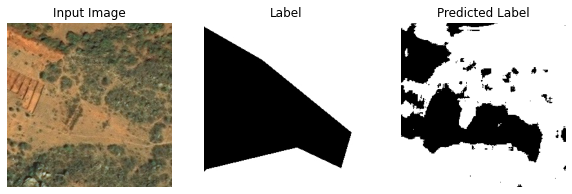


Sample Prediction after epoch 29

127/127 [==============================] - 90s 714ms/step - loss: 0.5310 - iou_coef: 0.6089 - dice_coef: 0.7003 - accuracy: 0.7311 - mse: 0.1746 - val_loss: 0.5215 - val_iou_coef: 0.6155 - val_dice_coef: 0.7088 - val_accuracy: 0.7522 - val_mse: 0.1708 - lr: 0.0010
Epoch 30/50
1/1 [==============================] - 0s 19ms/step


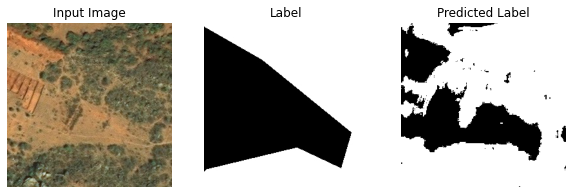


Sample Prediction after epoch 30

127/127 [==============================] - 91s 722ms/step - loss: 0.5275 - iou_coef: 0.6069 - dice_coef: 0.6983 - accuracy: 0.7323 - mse: 0.1732 - val_loss: 0.5160 - val_iou_coef: 0.6178 - val_dice_coef: 0.7099 - val_accuracy: 0.7550 - val_mse: 0.1689 - lr: 0.0010
Epoch 30: early stopping


In [22]:
# defining some hyperparameters
TRAIN_LENGTH = num_of_training_img
#128
STEPS_PER_EPOCH = TRAIN_LENGTH//BATCH_SIZE

EPOCHS = 50
TEST_SIZE = num_of_val_img
VALIDATION_STEPS = TEST_SIZE//BATCH_SIZE#//VAL_SUBSPLITS

model_history = model.fit(train_generator, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_generator,
                          callbacks=[DisplayCallback(), reduce_lr, early_stopping]
                          )

In [23]:
model.evaluate(test_generator, steps=num_of_test_img)

512/512 [==============================] - 68s 134ms/step - loss: 0.4896 - iou_coef: 0.6411 - dice_coef: 0.7357 - accuracy: 0.7708 - mse: 0.1585


[0.48964282870292664,
 0.6411295533180237,
 0.7357145547866821,
 0.7707629203796387,
 0.1584945172071457]

1/1 [==============================] - 0s 18ms/step
image shape (1, 256, 256, 3)
mask shape (1, 256, 256, 1)
pred_mask shape (1, 256, 256, 1)


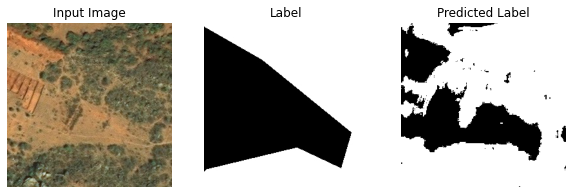

In [24]:
show_predictions(sample_generator)

1/1 [==============================] - 0s 28ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


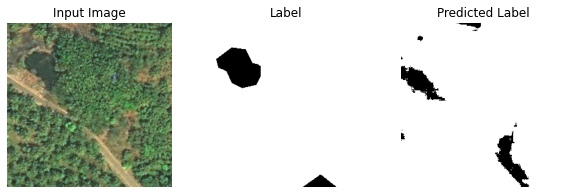

1/1 [==============================] - 0s 31ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


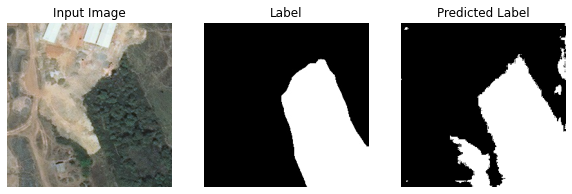

1/1 [==============================] - 0s 30ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


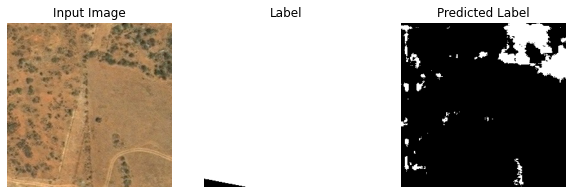

1/1 [==============================] - 0s 28ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


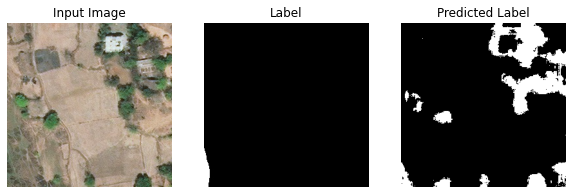

1/1 [==============================] - 0s 28ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


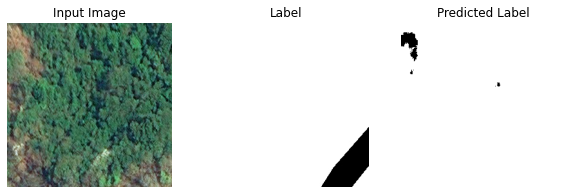

In [25]:
show_predictions(val_generator, 5)

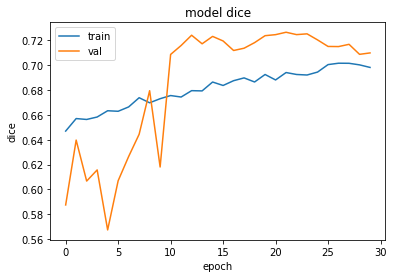

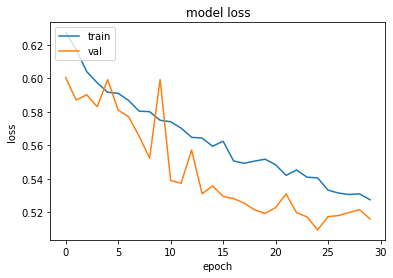

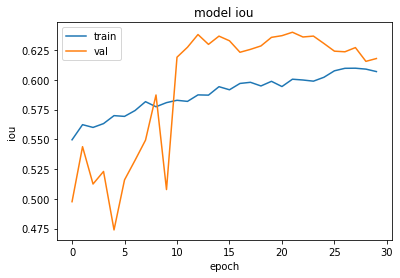

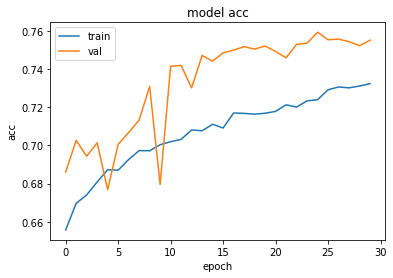

In [26]:
#dice
plt.plot(model_history.history['dice_coef'])
plt.plot(model_history.history['val_dice_coef'])
plt.title('model dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#iou
plt.plot(model_history.history['iou_coef'])
plt.plot(model_history.history['val_iou_coef'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
model.save('unet-c1-iou-norm.h5')